Reference:
H. Oh, “Recommender system for YouTube Using Deep Learning,” GitHub. 
[Online]. Available:  https://github.com/hyez/Deep-Youtube-Recommendations

In [1]:
# upload SwipEat_ Restaurant Recommendation Mobile Application_July 4, 2022_12.13.csv, restaurant_yelp_unique_refined.csv to data directory
# upload log_3.csv, log_4.csv, log_7.csv, log_9.csv, log_10.csv, log_13.csv, log_28.csv to logs directory
%cd "/content/drive/MyDrive/Colab/SwipEat"

/content/drive/MyDrive/Colab/SwipEat


In [3]:
from urllib.request import urlretrieve
import zipfile
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import string
import ast
import itertools
import math

# Survey Model

## Survey Data

In [4]:
df_survey = pd.read_csv("data/SwipEat_ Restaurant Recommendation Mobile Application_July 4, 2022_12.13.csv")
df_survey.head(5)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q5_97,Q5_98,Q5_99,Q5_100,Q5_101,Q5_102,Q5_6,Q5_3,Q5_2,Q5_1
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,Ratings of the restaurants that you have visit...,Ratings of the restaurants that you have visit...,Ratings of the restaurants that you have visit...,Ratings of the restaurants that you have visit...,Ratings of the restaurants that you have visit...,Ratings of the restaurants that you have visit...,Ratings of the restaurants that you have visit...,Ratings of the restaurants that you have visit...,Ratings of the restaurants that you have visit...,Ratings of the restaurants that you have visit...
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}",...,"{""ImportId"":""QID4_97""}","{""ImportId"":""QID4_98""}","{""ImportId"":""QID4_99""}","{""ImportId"":""QID4_100""}","{""ImportId"":""QID4_101""}","{""ImportId"":""QID4_102""}","{""ImportId"":""QID4_6""}","{""ImportId"":""QID4_3""}","{""ImportId"":""QID4_2""}","{""ImportId"":""QID4_1""}"
2,2022-06-19 08:37:42,2022-06-20 06:21:47,0,222.166.166.245,100,78244,1,2022-06-20 06:21:48,R_3O6v20u9fWRc24T,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-07-01 00:23:39,2022-07-01 00:47:19,0,112.118.150.196,100,1419,1,2022-07-01 00:47:19,R_1K38L1SgVyZi5PK,NaN,...,4,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-07-02 00:15:48,2022-07-02 00:19:05,0,58.153.92.76,100,196,1,2022-07-02 00:19:05,R_XGpYp3Jn2phWctH,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_user = df_survey[['Q1', 'Q2', 'Q3','Q4']].iloc[2:,:].reset_index(drop=True)
df_user.rename(columns = {'Q1':'gender', 'Q2':'age', 'Q3':'occupation', 'Q4':'preferences'}, inplace = True)
df_user['preferences'] = mylist = df_user['preferences'].apply(lambda x: [int(cat) for cat in x.split(',')])
df_user['userID'] = df_user.index + 1
df_user['gender'] = df_user['gender'].apply(int)
df_user['age'] = df_user['age'].apply(int)
df_user['occupation'] = df_user['occupation'].apply(int)
df_user.head(5)

,gender,age,occupation,preferences,userID
0,2,2,10,[7],1
1,1,3,11,"[10, 9, 17, 37, 30, 31]",2
2,1,6,3,"[9, 30]",3
3,2,6,1,"[2, 35, 7, 9, 30]",4
4,1,7,10,[9],5


In [ ]:
restaurant_names = df_survey.iloc[0,21:]
restaurant_names = restaurant_names.apply(lambda x: x.split('-')[1].strip())
restaurant_names_en = restaurant_names.apply(lambda x: x.split('(')[0].strip())
restaurant_names_cn = restaurant_names.apply(lambda x: x.split('('))
restaurant_names_cn = restaurant_names_cn.apply(lambda x: x[1].strip().replace(')', '') if len(x) > 1 else '')
print(restaurant_names.tolist())

['Tim Ho Wan (添好運)', 'Australia Dairy Company (澳洲牛奶公司)', 'Kam Wah Cafe (金華冰廳)', 'Yat Lok Restaurant (一樂燒鵝)', 'Kau Kee Restaurant (九記牛腩)', 'Din Tai Fung (鼎泰豐)', 'Ho Lee Fook (口利福)', "Kam's Roast Goose (甘牌燒鵝)", 'OZONE', 'Ichiran (一蘭)', 'Tsim Chai Kee Noodle (沾仔記)', "Mak's Noodle (麥奀雲吞麵世家)", 'One Dim Sum (一點心)', 'Mak Man Kee Noodle Shop (麥文記麵家)', 'Cheung Hing Kee Shanghai Pan', 'Cat Store (阿貓地攤)', 'Yardbird', 'Mott 32 (卅二公館)', 'Quinary', 'Lo Tak Court (路德圍)', 'Yung Kee Restaurant (鏞記酒家)', 'Lin Heung Tea House (蓮香茶室)', 'Tung Po (東寶小館)', 'Mana! Fast Slow Food', 'Aqua', 'Mammy Pancake (媽咪雞蛋仔)', 'Sister Wah (華姐清湯腩)', 'Paradise Dynasty (樂天皇朝)', 'Sevva', 'BBQ King (燒烤大王)', 'Ho Hung Kee (何洪記)', 'Loving Hut (愛家餐廳)', 'Chôm Chôm', 'Cafe Gray Deluxe', 'The Globe', 'The Butchers Club Burger', 'Casablanca Restaurant & Cafe', "Maxim's Palace (美心皇宮)", 'Daikiya Japanese Restaurant (大喜屋日本料理)', '22 Ships', 'Budaoweng Hotpot Cuisine (不倒翁中日火鍋料理)', 'Crystal Jade La Mian Xiao Long Bao (翡翠拉麵小籠包)', 'Bo Innovatio

In [ ]:
rname_to_column = dict(zip(restaurant_names.tolist(), df_survey.columns[21:]))
rname_to_id = {'Tim Ho Wan (添好運)': '1S2p1xBtwP20qb2JTMacsA', 
                   'Australia Dairy Company (澳洲牛奶公司)': 'bCu5W_9_NG78Mv6ZGVVVBQ',
                   'Kam Wah Cafe (金華冰廳)': '2h89smIl2aXxa2DyxSIFmg',
                   'Yat Lok Restaurant (一樂燒鵝)': '9bA-RHB9wRSZopviHgAtBA',
                   'Kau Kee Restaurant (九記牛腩)': 'uGXE3PweOJvLVpvBCGthVA',
                   'Din Tai Fung (鼎泰豐)': '-B7Wm3GPmdnbTj_etUo2Gw',
                   'Ho Lee Fook (口利福)': 'WH-i-EikQmX-WVMEf_rHMA',
                   "Kam's Roast Goose (甘牌燒鵝)": 'WzbWEbH_gRXYllbH7PL6gg',
                   'OZONE': '-f4oy1c5r9wMmDxl9oN2AA', 
                   'Ichiran (一蘭)': '2KJ0LOuvT2EQk67cY-5B-Q',
                   'Tsim Chai Kee Noodle (沾仔記)': 'H6wbsSPZFk3qQNrlw7-DrQ',
                   "Mak's Noodle (麥奀雲吞麵世家)": '4bRcKkQkH45JIhsMKN_GBA',
                   'One Dim Sum (一點心)': 'uNbyTuXlcbLJVQjeJTnsNg',
                   'Mak Man Kee Noodle Shop (麥文記麵家)': 'Y7tD6dOITATOOW7D1tUMPg',
                   'Cheung Hing Kee Shanghai Pan': 'BDEl41hkJ_15TzQUXY9FqQ',
                   'Cat Store (阿貓地攤)': 'qQbTyobkkaT4wQfDoLN8vQ',
                   'Yardbird': 'kSm89woWM9PdYNWYxNaTiw',
                   'Mott 32 (卅二公館)': '-N2PXjj3P6pcB-00uG2WvQ',
                   'Quinary': 'veVujRRySQkt1UfyICS1dg',
                   'Lo Tak Court (路德圍)': 'XUiefyhbsiPOUh5yq0S3UQ',
                   'Yung Kee Restaurant (鏞記酒家)': 'GxG0eeZLcfJupilWPFPK0A',
                   'Lin Heung Tea House (蓮香茶室)': '322WB-A-rSys6D83obWibQ',
                   'Tung Po (東寶小館)': 'guLkOXmo0lphnEn4rRF9dQ',
                   'Mana! Fast Slow Food': 'VJcRrCdA1tpi1TA35q-C5A',
                   'Aqua': 'ge64Cw_CKG1yEmqihViFwQ',
                   'Mammy Pancake (媽咪雞蛋仔)': 'oaN6JPRWtp7rHe8nvpox8w',
                   'Sister Wah (華姐清湯腩)': 'HmHjJoaMitpTiU--tJBUfA',
                   'Paradise Dynasty (樂天皇朝)': 'memO5IlPh7PV_vOvBpe_kg',
                   'Sevva': 'TnjvQUuZv1OEiiKa1_z0hQ',
                   'BBQ King (燒烤大王)': 'wFvYd2LYfoRfDii5ZJQsJw',
                   'Ho Hung Kee (何洪記)': 'zzoGDKxvggAgeglQuatoBg',
                   'Loving Hut (愛家餐廳)': 'p2xZmYS1X-J2OZgT5FcRxw',
                   'Chôm Chôm': 'hSTWR8_knNzq6rGmQJBCxw',
                   'Cafe Gray Deluxe': 'smHi4oyqqYgYHDB2tMFNqA',
                   'The Globe': 'O0Fezrw-Wq6p8iJ8bfbfxw',
                   'The Butchers Club Burger': 'fkHkCfhcZh205-pjGooS6A',
                   'Casablanca Restaurant & Cafe': 'V_XVoyLfz17zrFEFouf2tw',
                   "Maxim's Palace (美心皇宮)": '71mLAdl-PNd04XyRHMc6Wg',
                   'Daikiya Japanese Restaurant (大喜屋日本料理)': 'SZEeyBhHE3NaistN-Plogw',
                   '22 Ships': 'YtpjVyzSqhtS8BAYU70xSg',
                   'Budaoweng Hotpot Cuisine (不倒翁中日火鍋料理)': 'et_O3vdYZPXFYL9MfdZfag',
                   'Crystal Jade La Mian Xiao Long Bao (翡翠拉麵小籠包)': 'GrVY6AiOriiApojIYkw3Yg',
                   'Bo Innovation (廚魔)': 'b8r6Yj3IBFLF4zsMHZ3Jvw',
                   'Hutong (胡同)': 'W_gr0nT4E7-2sTyZzR6Zaw',
                   'Urban Coffee Roaster': 'o2DIXkhuzN1BBmygG6nQkQ',
                   'The Flying Pan': 'UGrlTLixpjr1aSKSx3NVkA',
                   'Butao Ramen (豚王)': 'u2BTSFBG2KYxPZ4gM4hq0A',
                   'The Cupping Room': 'fsy_vaW3jen4AE3tUnWjrA',
                   'Pirata': 'h71XV0wzGshQyx8H5ragxw',
                   'N1 Coffee & Co.': 'oDKn75GjIt-PwVzFEG7RmQ',
                   'BÊP Vietnamese Kitchen': 'qNePgUSkbTH5rB5IO6pbLA',
                   "L'Atelier de Joël Robuchon": 'oDmhxI7jVha15Kiyau1ZaQ',
                   'Oddies': 'fnuvNNGK4RqerGUNLidJJQ', 
                   'Brunch Club & Supper': '9kOoyL6yNSUCa6YTiWELsA', 
                   '8 1/2 Otto e Mezzo BOMBANA': 'cqsR9BbU9RJUqEOMJI0FIw', 
                   'Oolaa': 'rZ8AFcSxq_Yri61YS4uEVg', 
                   'Wooloomooloo Steakhouse': 'OTxNTe7KUKu2LQV55jxGEQ', 
                   'Shake Shack': 'vy-CrKB4FnUXHJfTm5VBnw', 
                   'Wooloomooloo Prime': 'GDRXsPCxMk1ezw7e6of48g', 
                   'La Vache!': 'rnNZFq240WrJNVEMZf8a4A', 
                   'Brickhouse': 'bEIMSYLmpNg3cKUfdFNtCQ', 
                   'Amber': '6kCKH68LggPYvcpzrcGGcQ', 
                   "Duddell's (都爹利會館)": 'OTBNcACGdj-j5XBEjtlNkA', 
                   'Cococabana': 'ABZHUzzHcQKaJ3TnK7mEPw', 
                   'Temple Spice Crabs (廟街辣蟹)': 'nLKCHBX7NJ98Xo5q1mJjIw', 
                   'Burger Joys': 'LTg4oknq381XRotpcOHXlQ', 
                   'The Pawn': 'FuEHRbxUWYMQZsHVUzT9-Q', 
                   'The Chairman (大班樓)': 'pdwWETX1rXKytiKf9sVN1Q', 
                   'Studio Caffeine': 'e8LnQbOeoRypi0e4zMNtpQ', 
                   '208 Duecento Otto': '9RstIqQpwGtBFWcu5Fjq1Q', 
                   'Bubba Gump (阿甘蝦餐廳)': 'KIdV0oPlAHCSx-0ytqepSw', 
                   'Beerliner German Bar and Restaurant': 'qLdKo9DXljlQ3wMVqk1spQ', 
                   'Motorino': 'ECzc_BRRh1J_ejtfJcjDUQ', 
                   'Ce La Vi': 'vdjUIinMXwdyE5meS62cbw', 
                   'Zuma': 'NDANpgAC-QOS2JWpWKY8Aw', 
                   'Hard Rock Cafe': 'vOMwzJ4GIfNGruNCqIRHuw', 
                   'Samsen': 'nuGfONXMMnaJVgShThtVPg', 
                   'Fei Jie (肥姐小食店)': 'AtSlMU6SYo2YqH8rfOnqCQ', 
                   'The Roundhouse Taproom': '9teucFV3MzjGvp6eY6srLA', 
                   'Holly Brown': '40QdP-h7Wk8lru7-Qa22Qw', 
                   "Jamie's Italian": 'IfSheYHl0J9WBudueWn00A', 
                   'Islam Food (清真牛肉館)': 'oWDGFlpe8i2ZflrnZv1Dcg', 
                   'Grassroots Pantry (豆苗居)': '9FdBnKTCrkHgPn7exOcS7Q', 
                   'Café 103': '_kPj2wr-jTBgNJZMkIBHwA', 
                   'Gaylord Indian Restaurant (爵樂印度餐廳)': 'qkX5NIBokiX34TNUUIQ-2w', 
                   'Ciao Chow': 'KHkHQBp5YNnlvk8wrpGINw', 
                   'Urban Bakery Works': 'uQNKaHXuC6Vjtw2hao4MbQ', 
                   'Coyote Bar & Grill': 'ewEviIQhWnjbUYv5NGg24A', 
                   'Felix': 'V_Zzwnx-s7VEsOmFrIZO-w', 
                   'Maison Libanaise': 'FSLbh_qNvoStwoOt8h2CEw', 
                   'Hot': 'zDJg4DDOTxoo_kQJiZVLEA', 
                   'Opendoor Cafe + Courtyard':'-UNekVpwYzYTkB7kJehOGQ', 
                   'The Alchemist Cafe Bistro (牧羊少年咖啡': '6rb8eaSI8gbZyhyGwikFyA', 
                   'London House': 'Zare2VHBuBwvnD1RyQILUQ', 
                   'Iberico & Co.': '8ap4VdG_2rZZLjJX1gwCnQ', 
                   'Pure Veggie House (心齋)': '8Q3Kb3fZbUxXNzdZH22cSw', 
                   'Odd One Out': 'TjbcE2w1DSF6Qgx5U19ulw', 
                   'Ho Hak Shan Tung (好客山東)': 'ofT6aCTeztWrwmTGst96aA', 
                   'Life Café': 'Ndl11qtPnloZ0C4y5ieCgg', 
                   'Prompt': 'MZq6AmHqaHnVmmSNgoX1dw'}
column_idx_to_rid = dict(zip(rname_to_column.values(), rname_to_id.values()))

In [ ]:
df_restaurant = pd.read_csv("data/restaurant_yelp_unique_refined.csv")
df_restaurant['categories'] = df_restaurant['categories'].apply(lambda x: ast.literal_eval(x))
df_restaurant['price'] = df_restaurant['price'].apply(lambda x: len(x) if not pd.isnull(x) else 0)

# fill empty/0
# normalize price and rating
sum_price = 0
valid_price_cnt = 0
for i in range(df_restaurant.shape[0]):
  if df_restaurant['price'][i] > 0 :
    sum_price = sum_price + df_restaurant['price'][i]
    valid_price_cnt = valid_price_cnt + 1

mean_price = sum_price/float(valid_price_cnt)
print("mean_price: ", mean_price)
df_restaurant['price'] = df_restaurant['price'].apply(lambda x: mean_price if x == 0 else x)
df_restaurant['price'] = (df_restaurant['price']-1.0)/(4.0-1.0)


df_restaurant['rating'] = df_restaurant['rating'].fillna(0.0)
sum_rating = 0
valid_rating_cnt = 0
for i in range(df_restaurant.shape[0]):
  if df_restaurant['rating'][i] > 0 :
    sum_rating = sum_rating + df_restaurant['rating'][i]
    valid_rating_cnt = valid_rating_cnt + 1

mean_rating = sum_rating/float(valid_rating_cnt)
print("mean_rating: ", mean_rating)
df_restaurant['rating'] = df_restaurant['rating'].apply(lambda x: mean_rating if x == 0 else x)
df_restaurant['rating'] = (df_restaurant['rating'] - 1.0) / (5.0-1.0)


df_restaurant['id'] = df_restaurant['id'].str.strip()
df_restaurant.head(5)

mean_price:  1.8306323482681919
mean_rating:  3.7552635200220172


,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,location,display_phone,price,locale_name,has_chinese_name,chinese_address,english_address,latitude,longitude
0,MZq6AmHqaHnVmmSNgoX1dw,prompt-香港,Prompt,https://s3-media2.fl.yelpcdn.com/bphoto/XKofu7...,False,https://www.yelp.com/biz/prompt-%E9%A6%99%E6%B...,3,[Restaurants],0.750,"{'latitude': 22.261902, 'longitude': 114.129596}","{'address1': '數碼港道100號數碼港艾美酒店', 'address2': No...",+852 2980 7417,0.276877,prompt,False,數碼港道100號數碼港艾美酒店,"Le Meridien Cyberport, 100 Cyberport Road",22.261902,114.129596
1,1S2p1xBtwP20qb2JTMacsA,添好運點心專門店-香港,Tim Ho Wan,https://s3-media4.fl.yelpcdn.com/bphoto/hx18Hs...,False,https://www.yelp.com/biz/%E6%B7%BB%E5%A5%BD%E9...,441,"[Cantonese, Dim Sum]",0.750,"{'latitude': 22.2845779275192, 'longitude': 11...","{'address1': '港景街1號', 'address2': 'L1樓12A號舖', ...",+852 2332 3078,0.333333,添好運點心專門店,True,港景街1號L1樓12A號舖,"Shop 12A, L1/F, 1 Harbour View Street",22.284578,114.158152
2,bCu5W_9_NG78Mv6ZGVVVBQ,澳洲牛奶公司-香港-2,Australia Dairy Company,https://s3-media4.fl.yelpcdn.com/bphoto/FHuDpD...,False,https://www.yelp.com/biz/%E6%BE%B3%E6%B4%B2%E7...,406,"[Hong Kong Style Cafe, Desserts, Coffee & Tea]",0.750,"{'latitude': 22.3046, 'longitude': 114.170501}","{'address1': '白加士街47-49號', 'address2': '地下', '...",+852 2730 1356,0.000000,澳洲牛奶公司,True,白加士街47-49號地下,"G/F, 47-49 Parkes Street",22.304600,114.170501
3,2h89smIl2aXxa2DyxSIFmg,金華冰廳-kowloon,Kam Wah Cafe,https://s3-media2.fl.yelpcdn.com/bphoto/PEyGoI...,False,https://www.yelp.com/biz/%E9%87%91%E8%8F%AF%E5...,233,"[Hong Kong Style Cafe, Bakeries]",0.875,"{'latitude': 22.322313, 'longitude': 114.1697786}","{'address1': '弼街47號', 'address2': '地下', 'addre...",+852 2392 6830,0.000000,金華冰廳 kowloon,True,弼街47號地下,"G/F, 47 Bute Street",22.322313,114.169779
4,10540KOwjB55TfK26p51SQ,添好運-香港-6,Tim Ho Wan,https://s3-media3.fl.yelpcdn.com/bphoto/Rzoduj...,False,https://www.yelp.com/biz/%E6%B7%BB%E5%A5%BD%E9...,225,"[Cantonese, Dim Sum]",0.750,"{'latitude': 22.329047, 'longitude': 114.166336}","{'address1': '福榮街9-11號', 'address2': '地下', 'ad...",+852 2788 1226,0.000000,添好運,True,福榮街9-11號地下,"G/F, 9-11 Fuk Wing Street",22.329047,114.166336


In [ ]:
pd.set_option('max_colwidth', 30)
pd.set_option('max_rows', 200)
restaurant_id = df_restaurant[df_restaurant['name'].isin(restaurant_names_en.tolist())]
restaurant_id = restaurant_id[~restaurant_id['alias'].str[-1].str.isdigit()]
restaurant_id = pd.concat([restaurant_id, df_restaurant[df_restaurant['name'].isin(restaurant_names_cn.tolist())]])
restaurant_id

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,location,display_phone,price,locale_name,has_chinese_name,chinese_address,english_address,latitude,longitude
0,MZq6AmHqaHnVmmSNgoX1dw,prompt-香港,Prompt,https://s3-media2.fl.yelpc...,False,https://www.yelp.com/biz/p...,3,[Restaurants],0.750,"{'latitude': 22.261902, 'l...",{'address1': '數碼港道100號數碼港艾...,+852 2980 7417,0.276877,prompt,False,數碼港道100號數碼港艾美酒店,"Le Meridien Cyberport, 100...",22.261902,114.129596
1,1S2p1xBtwP20qb2JTMacsA,添好運點心專門店-香港,Tim Ho Wan,https://s3-media4.fl.yelpc...,False,https://www.yelp.com/biz/%...,441,"[Cantonese, Dim Sum]",0.750,{'latitude': 22.2845779275...,"{'address1': '港景街1號', 'add...",+852 2332 3078,0.333333,添好運點心專門店,True,港景街1號L1樓12A號舖,"Shop 12A, L1/F, 1 Harbour ...",22.284578,114.158152
3,2h89smIl2aXxa2DyxSIFmg,金華冰廳-kowloon,Kam Wah Cafe,https://s3-media2.fl.yelpc...,False,https://www.yelp.com/biz/%...,233,"[Hong Kong Style Cafe, Bak...",0.875,"{'latitude': 22.322313, 'l...","{'address1': '弼街47號', 'add...",+852 2392 6830,0.000000,金華冰廳 kowloon,True,弼街47號地下,"G/F, 47 Bute Street",22.322313,114.169779
5,9bA-RHB9wRSZopviHgAtBA,一樂燒鵝-香港,Yat Lok Restaurant,https://s3-media2.fl.yelpc...,False,https://www.yelp.com/biz/%...,197,"[Cantonese, Barbeque]",0.750,"{'latitude': 22.282556, 'l...","{'address1': '士丹利街34-38號',...",+852 2524 3882,0.333333,一樂燒鵝,True,士丹利街34-38號地舖,"G/F, 34-38 Stanley Street",22.282556,114.155308
6,uGXE3PweOJvLVpvBCGthVA,九記牛腩-香港,Kau Kee Restaurant,https://s3-media1.fl.yelpc...,False,https://www.yelp.com/biz/%...,185,"[Cantonese, Noodles]",0.750,"{'latitude': 22.284257, 'l...","{'address1': '歌賦街21號', 'ad...",+852 2850 5967,0.000000,九記牛腩,True,歌賦街21號地下,"G/F, 21 Gough Street",22.284257,114.152543
9,WH-i-EikQmX-WVMEf_rHMA,口利福-香港,Ho Lee Fook,https://s3-media1.fl.yelpc...,False,https://www.yelp.com/biz/%...,136,"[Asian Fusion, Cantonese]",0.875,"{'latitude': 22.28291, 'lo...","{'address1': '伊利近街1-5號', '...",+852 2810 0860,0.666667,口利福,True,伊利近街1-5號地下,"G/F, 1-5 Elgin Street",22.282910,114.152450
10,WzbWEbH_gRXYllbH7PL6gg,甘牌燒鵝-香港,Kam's Roast Goose,https://s3-media2.fl.yelpc...,False,https://www.yelp.com/biz/%...,133,[Cantonese],0.750,"{'latitude': 22.27774, 'lo...","{'address1': '軒尼詩道226號', '...",+852 2520 1110,0.333333,甘牌燒鵝,True,軒尼詩道226號地下,"G/F, 226 Hennessy Road",22.277740,114.175310
12,-f4oy1c5r9wMmDxl9oN2AA,ozone-kowloon,OZONE,https://s3-media2.fl.yelpc...,False,https://www.yelp.com/biz/o...,129,"[Japanese, Lounges, Asian ...",0.625,{'latitude': 22.3035410853...,"{'address1': 'Level 118, I...",+852 2263 2270,0.666667,ozone kowloon,False,"Level 118, International C...","118/F, 1 Austin Road West",22.303541,114.160223
13,2KJ0LOuvT2EQk67cY-5B-Q,天然豚骨拉麵專門店一蘭-香港,Ichiran,https://s3-media3.fl.yelpc...,False,https://www.yelp.com/biz/%...,122,[Ramen],0.750,"{'latitude': 22.2804876, '...",{'address1': '謝斐道440-446號駱...,+852 2116 4802,0.333333,天然豚骨拉麵專門店一蘭,True,謝斐道440-446號駱克大樓A座地下F-I舖,"Shop F-I, G/F, Block A, Lo...",22.280488,114.181533
14,H6wbsSPZFk3qQNrlw7-DrQ,沾仔記-香港,Tsim Chai Kee Noodle,https://s3-media2.fl.yelpc...,False,https://www.yelp.com/biz/%...,113,[Noodles],0.750,"{'latitude': 22.282966, 'l...","{'address1': '威靈頓街98號', 'a...",+852 2850 6471,0.000000,沾仔記,True,威靈頓街98號地下,"G/F, 98 Wellington Street",22.282966,114.154463


In [ ]:
# create dataframe with the user ratings
user_restaurant_hist = []
for row_idx in range(4, df_survey.shape[0]):
  for column_idx in range(21, 121):
    if type(df_survey.iloc[row_idx, column_idx]) == float:
      if not math.isnan(df_survey.iloc[row_idx, column_idx]):
        user_restaurant_hist.append([row_idx-3, column_idx_to_rid[df_survey.columns[column_idx]], float(df_survey.iloc[row_idx, column_idx])])
    else:
      if df_survey.iloc[row_idx, column_idx] != 'NaN':
        user_restaurant_hist.append([row_idx-3, column_idx_to_rid[df_survey.columns[column_idx]], float(df_survey.iloc[row_idx, column_idx])])
df_user_ratings = pd.DataFrame(user_restaurant_hist, columns=['userID', 'restaurantID', 'rating'])

In [ ]:
# show the unique restaurant categories collected from Yelp
categories = df_restaurant['categories']
tmp_list = []
for category in categories:
  for cat in category:
    tmp_list.append(cat)
print(set(tmp_list))
print(len(set(tmp_list)))
feature_mapping = dict(list(zip(set(tmp_list), list(range(1,len(set(tmp_list))+1)))))

{'Mini Golf', 'Books, Mags, Music & Video', 'International Grocery', 'Sri Lankan', 'Restaurants', 'Herbs & Spices', 'Cooking Schools', 'Patisserie/Cake Shop', 'Themed Cafes', 'Candy Stores', 'Lounges', 'Cafes', 'Whiskey Bars', 'Indonesian', 'Photographers', 'Pekinese', 'Japanese Curry', 'Print Media', 'Farms', 'Pool & Billiards', 'Cajun/Creole', 'Pakistani', 'Nightlife', 'Singaporean', 'Bubble Tea', 'Bookstores', 'Public Plazas', 'Thai', 'Fuzhou', 'Pizza', 'Waffles', 'Fish & Chips', 'Cocktail Bars', 'Shopping', 'Butcher', 'Sports Bars', 'Pan Asian', 'Kebab', 'Wine Bars', 'Pets', 'Donuts', 'Traditional Chinese Medicine', 'Fashion', 'Australian', 'International', 'Brasseries', 'Brazilian', 'Beer Bar', 'Sports Clubs', 'Szechuan', 'Ukrainian', 'Middle Eastern', 'Shanghainese', 'Hot Pot', 'Wholesale Stores', 'Portuguese', 'Izakaya', 'Food Court', 'Horseback Riding', 'Soup', 'Sushi Bars', 'Pancakes', 'Wineries', 'Bars', 'Tea Rooms', 'Russian', 'Art Schools', 'Parking', 'Spanish', 'Moroccan',

In [ ]:
# grouped mapping
feature_mapping = {'African': 30,
 'American (Traditional)': 29,
 'Arabic': 34,
 'Argentine': 29,
 'Art Galleries': 1,
 'Art Schools': 1,
 'Art Space Rentals': 1,
 'Arts & Crafts': 1,
 'Arts & Entertainment': 1,
 'Asian Fusion': 2,
 'Australian': 29,
 'Bagels': 3,
 'Bakeries': 3,
 'Barbeque': 4,
 'Bars': 5,
 'Basque': 31,
 'Beauty & Spas': 6,
 'Beer Bar': 5,
 'Beer, Wine & Spirits': 28,
 'Belgian': 31,
 'Bistros': 7,
 'Boating': 16,
 'Books, Mags, Music & Video': 1,
 'Bookstores': 1,
 'Bowling': 16,
 'Brasseries': 7,
 'Brazilian': 29,
 'Breakfast & Brunch': 26,
 'Breweries': 28,
 'Brewpubs': 28,
 'British': 31,
 'Bubble Tea': 20,
 'Buffets': 8,
 'Burgers': 17,
 'Butcher': 29,
 'Cafes': 10,
 'Cafeteria': 10,
 'Cajun/Creole': 29,
 'Candy Stores': 14,
 'Cantonese': 12,
 'Caribbean': 34,
 'Caterers': 16,
 'Champagne Bars': 5,
 'Cheese Shops': 13,
 'Chicken Shop': 11,
 'Chicken Wings': 11,
 'Chinese': 12,
 'Cocktail Bars': 5,
 'Coffee & Tea': 9,
 'Coffee Roasteries': 9,
 'Congee': 12,
 'Convenience Stores': 26,
 'Conveyor Belt Sushi': 33,
 'Cooking Schools': 6,
 'Creperies': 14,
 'Cultural Center': 1,
 'Dance Clubs': 5,
 'Delicatessen': 13,
 'Delis': 13,
 'Desserts': 14,
 'Dim Sum': 12,
 'Diners': 28,
 'Dive Bars': 5,
 'Do-It-Yourself Food': 15,
 'Donuts': 14,
 'Farmers Market': 16,
 'Farms': 16,
 'Fashion': 1,
 'Fast Food': 17,
 'Ferries': 16,
 'Filipino': 32,
 'Fish & Chips': 31,
 'Fishing': 16,
 'Florists': 16,
 'Fondue': 31,
 'Food': 35,
 'Food Court': 17,
 'Food Delivery Services': 13,
 'Food Stands': 17,
 'French': 31,
 'Fuzhou': 12,
 'Gastropubs': 5,
 'German': 31,
 'Gluten-Free': 18,
 'Greek': 31,
 'Grocery': 25,
 'Hainan': 12,
 'Hakka': 32,
 'Halal': 34,
 'Hawaiian': 29,
 'Hawker Centre': 17,
 'Health Markets': 26,
 'Herbs & Spices': 27,
 'Himalayan/Nepalese': 32,
 'Home Decor': 25,
 'Hong Kong Style Cafe': 12,
 'Hookah Bars': 5,
 'Horseback Riding': 16,
 'Hot Dogs': 17,
 'Hot Pot': 19,
 'Hunan': 12,
 'Ice Cream & Frozen Yogurt': 14,
 'Imported Food': 35,
 'Indian': 32,
 'Indonesian': 32,
 'International': 31,
 'International Grocery': 25,
 'Irish': 31,
 'Irish Pub': 5,
 'Italian': 31,
 'Izakaya': 33,
 'Japanese': 33,
 'Japanese Curry': 33,
 'Juice Bars & Smoothies': 20,
 'Karaoke': 16,
 'Kebab': 30,
 'Korean': 32,
 'Kosher': 34,
 'Landmarks & Historical Buildings': 21,
 'Latin American': 29,
 'Live/Raw Food': 32,
 'Local Flavor': 35,
 'Lounges': 28,
 'Mah Jong Halls': 16,
 'Malaysian': 32,
 'Meat Shops': 25,
 'Mediterranean': 34,
 'Mexican': 29,
 'Middle Eastern': 34,
 'Mini Golf': 16,
 'Modern European': 31,
 'Mongolian': 32,
 'Moroccan': 30,
 'Music Venues': 16,
 'Nightlife': 16,
 'Noodles': 22,
 'Organic Stores': 25,
 'Pakistani': 32,
 'Pan Asian': 32,
 'Pancakes': 14,
 'Parking': 23,
 'Parks': 16,
 'Patisserie/Cake Shop': 14,
 'Pekinese': 12,
 'Personal Shopping': 25,
 'Peruvian': 29,
 'Pet Services': 24,
 'Pet Stores': 24,
 'Pets': 24,
 'Pharmacy': 35,
 'Photographers': 16,
 'Pizza': 31,
 'Pool & Billiards': 16,
 'Portuguese': 31,
 'Print Media': 1,
 'Professional Services': 25,
 'Public Plazas': 25,
 'Pubs': 5,
 'Ramen': 33,
 'Restaurants': 35,
 'Robatayaki': 4,
 'Russian': 31,
 'Salad': 26,
 'Sandwiches': 26,
 'Scandinavian': 31,
 'Seafood': 35,
 'Shanghainese': 12,
 'Shared Office Spaces': 16,
 'Shopping': 25,
 'Shopping Centers': 25,
 'Singaporean': 32,
 'Social Clubs': 16,
 'Soup': 35,
 'Spanish': 31,
 'Specialty Food': 35,
 'Specialty Schools': 35,
 'Sports Bars': 5,
 'Sports Clubs': 5,
 'Sri Lankan': 32,
 'Steakhouses': 29,
 'Street Vendors': 17,
 'Supernatural Readings': 35,
 'Sushi Bars': 33,
 'Szechuan': 12,
 'Taiwanese': 12,
 'Tapas Bars': 5,
 'Tapas/Small Plates': 26,
 'Tea Rooms': 9,
 'Teochew': 12,
 'Teppanyaki': 33,
 'Tex-Mex': 29,
 'Thai': 32,
 'Themed Cafes': 10,
 'Traditional Chinese Medicine': 35,
 'Turkish': 32,
 'Udon': 33,
 'Ukrainian': 31,
 'Vegan': 27,
 'Vegetarian': 27,
 'Venues & Event Spaces': 16,
 'Vietnamese': 32,
 'Waffles': 14,
 'Wedding Planning': 35,
 'Whiskey Bars': 5,
 'Wholesale Stores': 25,
 'Wine Bars': 5,
 'Wineries': 28}

In [ ]:
# map integer to the restaurant categories
df_restaurant['categories'] = df_restaurant['categories'].apply(lambda x: [feature_mapping[category] for category in x])

In [ ]:
# concat price, categories and rating to the dataframe
df_user_ratings['price'] = df_user_ratings['restaurantID'].apply(lambda x: df_restaurant[df_restaurant['id'] == x]['price'].values[0])
df_user_ratings['r_categories'] = df_user_ratings['restaurantID'].apply(lambda x: df_restaurant[df_restaurant['id'] == x]['categories'].values[0])
df_user_ratings['rating'] = df_user_ratings['rating'].apply(lambda x: (x-1.0)/(5.0-1.0))
df_user_ratings.head(5)

,userID,restaurantID,rating,price,r_categories
0,1,1S2p1xBtwP20qb2JTMacsA,0.875,0.333333,"[12, 12]"
1,1,9bA-RHB9wRSZopviHgAtBA,0.875,0.333333,"[12, 4]"
2,1,-B7Wm3GPmdnbTj_etUo2Gw,0.875,0.333333,"[12, 12, 12]"
3,1,WzbWEbH_gRXYllbH7PL6gg,0.900,0.333333,[12]
4,1,BDEl41hkJ_15TzQUXY9FqQ,0.825,0.000000,[12]


3 features for each restaurant, concatenate to form a list of max length 15

In [ ]:
# create array of user_rating, overall_rating, target_price, features, hist_ratings, hist_price, hist_features
cur_user = df_user_ratings['userID'][0]
hist_list = []
hist_list.append(df_user_ratings.iloc[0][['rating']].values.tolist() + 
                 df_user_ratings.iloc[0][['restaurantID']].values.tolist() +
                  df_restaurant[df_restaurant['id'] == df_user_ratings.iloc[0]['restaurantID']]['rating'].values.tolist() + 
                  df_restaurant.iloc[0][['price', 'categories']].values.tolist() +
                  [0.0, 0.0, [0]] + 
                  df_user[df_user['userID'] == df_user_ratings.iloc[0]['userID']][['age', 'gender', 'occupation']].values.tolist()[0])
r_cnt = 0
price_valid_cnt = 0
rating_valid_cnt = 0

for i in range(1, df_user_ratings.shape[0]):

  if cur_user == df_user_ratings['userID'][i]:
    r_cnt = r_cnt + 1
    cur_hist = []
    avg_price = 0.0
    avg_rating = 0.0
    rcat_hist = []

    for j in range(1, r_cnt+1):

      if df_user_ratings['price'][i-j] != 0:
        price_valid_cnt = price_valid_cnt + 1
      if df_user_ratings['rating'][i-j] != 0:
        rating_valid_cnt = rating_valid_cnt + 1
      avg_price = avg_price + df_user_ratings['price'][i-j]
      avg_rating = avg_rating + df_user_ratings['rating'][i-j]

      if len(rcat_hist) < 15:
        feature_len = len(df_user_ratings['r_categories'][i-j])
        if feature_len >= 3:
          rcat_hist.extend(random.sample(df_user_ratings['r_categories'][i-j], 3))
        else:
          for k in range(feature_len):
            rcat_hist.append(df_user_ratings['r_categories'][i-j][k])
          for k in range(feature_len, 3):
            rcat_hist.append(0)

    if price_valid_cnt > 0:
      avg_price = avg_price / float(price_valid_cnt)
    if rating_valid_cnt > 0:
      avg_rating = avg_rating / float(rating_valid_cnt)

    hist_list.append([df_user_ratings['rating'][i], 
                      df_user_ratings['restaurantID'][i], 
                      df_restaurant[df_restaurant['id'] == df_user_ratings.iloc[i]['restaurantID']]['rating'].values.tolist()[0],
                      df_user_ratings['price'][i], 
                      df_user_ratings['r_categories'][i], 
                      avg_rating, 
                      avg_price, 
                      rcat_hist
                      ] + 
                     df_user[df_user['userID'] == df_user_ratings.iloc[i]['userID']][['age', 'gender', 'occupation']].values.tolist()[0])

  else:
    cur_user = df_user_ratings['userID'][i]
    r_cnt = 0
    price_valid_cnt = 0
    rating_valid_cnt = 0
    hist_list.append([df_user_ratings['rating'][i], 
                      df_user_ratings['restaurantID'][i], 
                      df_restaurant[df_restaurant['id'] == df_user_ratings.iloc[i]['restaurantID']]['rating'].values.tolist()[0],
                      df_user_ratings['price'][i], 
                      df_user_ratings['r_categories'][i], 
                      0.0, 0.0, [0]] + 
                     df_user[df_user['userID'] == df_user_ratings.iloc[i]['userID']][['age', 'gender', 'occupation']].values.tolist()[0])
    # hist_list.append([df_rating_final['rating'][i], df_rating_final['price'][i], df_rating_final['r_categories'][i]])


In [ ]:
hist_list[3]

[0.8999999999999999,
 'WzbWEbH_gRXYllbH7PL6gg',
 0.75,
 0.3333333333333333,
 [12],
 0.4375,
 0.16666666666666666,
 [12, 12, 12, 12, 4, 0, 12, 12, 0],
 2,
 2,
 10]

In [ ]:
len(hist_list)

1153

In [ ]:
df_rhist = pd.DataFrame(hist_list, columns=['user_rating', 'rid', 'overall_rating', 'target_price', 'features', 'hist_ratings', 'hist_price', 'hist_features', 'age', 'gender','occupation'])

In [ ]:
df_rhist.head(5)

,user_rating,rid,overall_rating,target_price,features,hist_ratings,hist_price,hist_features,age,gender,occupation
0,0.875,1S2p1xBtwP20qb2JTMacsA,0.750,0.276877,[35],0.000000,0.000000,[0],2,2,10
1,0.875,9bA-RHB9wRSZopviHgAtBA,0.750,0.333333,"[12, 4]",0.875000,0.333333,"[12, 12, 0]",2,2,10
2,0.875,-B7Wm3GPmdnbTj_etUo2Gw,0.875,0.333333,"[12, 12, 12]",0.583333,0.222222,"[12, 4, 0, 12, 12, 0]",2,2,10
3,0.900,WzbWEbH_gRXYllbH7PL6gg,0.750,0.333333,[12],0.437500,0.166667,"[12, 12, 12, 12, 4, 0, 12,...",2,2,10
4,0.825,BDEl41hkJ_15TzQUXY9FqQ,0.875,0.000000,[12],0.352500,0.133333,"[12, 0, 0, 12, 12, 12, 12,...",2,2,10


Generate training set, validation set and test set

In [ ]:
df_train_x = df_rhist[['user_rating', 'rid', 'overall_rating', 'target_price', 'features', 'hist_ratings', 'hist_price', 'hist_features','age', 'gender', 'occupation']].sample(frac=0.8, random_state=200)
train_y = tf.convert_to_tensor(df_train_x['user_rating'], dtype=float)
train_hist_features = tf.keras.preprocessing.sequence.pad_sequences(df_train_x['hist_features'], maxlen=15, padding='post')
train_features = tf.keras.preprocessing.sequence.pad_sequences(df_train_x['features'], maxlen=3, padding='post')

In [ ]:
df_validate_x = df_rhist[['user_rating', 'rid', 'overall_rating', 'target_price', 'features', 'hist_ratings', 'hist_price', 'hist_features','age', 'gender', 'occupation']].drop(df_train_x.index).sample(frac=0.5, random_state=200)
validate_y = tf.convert_to_tensor(df_validate_x['user_rating'], dtype=float)
validate_hist_features = tf.keras.preprocessing.sequence.pad_sequences(df_validate_x['hist_features'], maxlen=15, padding='post')
validate_features = tf.keras.preprocessing.sequence.pad_sequences(df_validate_x['features'], maxlen=3, padding='post')

In [ ]:
df_test_x = df_rhist[['user_rating', 'rid', 'overall_rating', 'target_price', 'features', 'hist_ratings', 'hist_price', 'hist_features','age', 'gender', 'occupation']].drop(df_train_x.index).drop(df_validate_x.index)
test_y = tf.convert_to_tensor(df_test_x['user_rating'], dtype=float)
test_hist_features = tf.keras.preprocessing.sequence.pad_sequences(df_test_x['hist_features'], maxlen=15, padding='post')
test_features = tf.keras.preprocessing.sequence.pad_sequences(df_test_x['features'], maxlen=3, padding='post')

In [ ]:
print("train set size: ", df_train_x.shape, train_y.shape)
print("validation set size: ", df_validate_x.shape, validate_y.shape)
print("test set size: ", df_test_x.shape, test_y.shape)

train set size:  (922, 11) (922,)
validation set size:  (116, 11) (116,)
test set size:  (115, 11) (115,)


## Survey Model

In [ ]:
EMBEDDING_DIMS = 64
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES = 11
NUM_CLASSES_IDS=22
NUM_CLASSES_FEATURES=300
NUM_CLASSES_OTHERS=100
LEARNING_RATE = 0.01

In [ ]:
# inputs
import tensorflow as tf
import datetime
import os
input_features_hist = tf.keras.Input(shape=(None, ), name='features_hist')
input_ids_hist = tf.keras.layers.Input(shape=(None,), name='ids_hist')
input_features = tf.keras.Input(shape=(3, ), name='features')
input_prices_hist = tf.keras.layers.Input(shape=(1,), name='prices_hist')
input_ratings_hist = tf.keras.Input(shape=(1, ), name='ratings_hist')
input_price = tf.keras.Input(shape=(1, ), name='prices')
input_rating = tf.keras.Input(shape=(1, ), name='ratings')
input_occupation = tf.keras.Input(shape=(1, ), name='occupation')
input_age = tf.keras.Input(shape=(1, ), name='age')
input_gender = tf.keras.Input(shape=(1, ), name='gender')

In [ ]:
# load model for testing
# loaded_model = tf.keras.models.load_model('model/model_111.h5')

In [ ]:
# layers
input_features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES_FEATURES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='input_features_embeddings')
hist_features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES_FEATURES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='hist_features_embeddings')

dense_1 = tf.keras.layers.Dense(units=128, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=64, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=32, name='dense_3')

dropout_1 = tf.keras.layers.Dropout(0.2)

dense_output = tf.keras.layers.Dense(1, activation=tf.nn.relu, name='dense_output')

In [ ]:
# embedding layers
input_features_embeddings = input_features_embedding_layer(input_features)
l2_norm_input_features = tf.math.l2_normalize(input_features_embeddings, axis=-1)
avg_input_features = tf.reduce_mean(l2_norm_input_features, axis=1)

labels_features_embeddings = hist_features_embedding_layer(input_features_hist)
l2_norm_features = tf.math.l2_normalize(labels_features_embeddings, axis=-1)
avg_features = tf.reduce_mean(l2_norm_features, axis=1)

# input feature vector
concat_inputs = tf.keras.layers.Concatenate(axis=1)([input_rating, input_price,
                                                     avg_input_features,
                                                     input_ratings_hist,
                                                     input_prices_hist,
                                                     avg_features,
                                                    #  input_age,
                                                     input_gender,
                                                     input_occupation])

# Dense Layers
dense_1_dropout = dropout_1(concat_inputs)
dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_dropout = dropout_1(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
# dense_2_dropout = dropout_1(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)

outputs = dense_output(dense_3_relu)

# optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model = tf.keras.models.Model(
    inputs=[input_rating,
            input_price,
            input_features,
            input_ratings_hist, 
            input_prices_hist,
            input_features_hist,
            # input_age,
            input_gender,
            input_occupation],
    outputs=[outputs]
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(optimizer=optimiser, loss='mean_squared_error')

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 features (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 features_hist (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 input_features_embeddings (Emb  (None, 3, 64)       19200       ['features[0][0]']               
 edding)                                                                                          
                                                                                                  
 hist_features_embeddings (Embe  (None, None, 64)    19200       ['features_hist[0][0]']   

In [ ]:
# callback to evaluate the performance in each epoch with test set
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_x, test_y, test_features, test_hist_features):
        super().__init__()
        self.test_x = test_x
        self.test_y = test_y
        self.test_features = test_features
        self.test_hist_features = test_hist_features
        self.loss_fn = tf.keras.losses.MeanSquaredError() 

    # def on_epoch_end(self, epoch, logs=None):
    #     test_rating = self.model.evaluate([self.test_x['overall_rating'], self.test_x['target_price'], 
    #                 self.test_features, self.test_x['hist_ratings'], 
    #                 self.test_x['hist_price'], self.test_hist_features,
    #                 self.test_x['age'], self.test_x['gender'], self.test_x['occupation']], self.test_y, verbose=0)
    #     logs['test_loss'] = test_rating

    def on_epoch_end(self, epoch, logs=None):
        test_rating = self.model.evaluate([self.test_x['overall_rating'], self.test_x['target_price'], 
                    self.test_features, self.test_x['hist_ratings'], 
                    self.test_x['hist_price'], self.test_hist_features,
                    self.test_x['gender'], self.test_x['occupation']], self.test_y, verbose=0)
        logs['test_loss'] = test_rating


## Train

In [ ]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/log_29.csv', append=True, separator=',')
# history = model.fit([df_train_x['overall_rating'], df_train_x['target_price'], 
#                     train_features, df_train_x['hist_ratings'], 
#                     df_train_x['hist_price'], train_hist_features,
#                     df_train_x['age'], df_train_x['gender'], df_train_x['occupation']],
#                     train_y, steps_per_epoch=10, epochs=200, 
#                     callbacks= [TestCallback(df_test_x, test_y, test_features, test_hist_features), csv_logger], 
#                     validation_data=([df_validate_x['overall_rating'], df_validate_x['target_price'], 
#                     validate_features, df_validate_x['hist_ratings'], 
#                     df_validate_x['hist_price'], validate_hist_features,
#                     df_validate_x['age'], df_validate_x['gender'], df_validate_x['occupation']], validate_y),
#                     batch_size = 64)

# start training and evaluate with validation set
history = model.fit([df_train_x['overall_rating'], df_train_x['target_price'], 
                    train_features, df_train_x['hist_ratings'], 
                    df_train_x['hist_price'], train_hist_features,
                    df_train_x['gender'], df_train_x['occupation']],
                    train_y, steps_per_epoch=10, epochs=200, 
                    callbacks= [TestCallback(df_test_x, test_y, test_features, test_hist_features), csv_logger], 
                    validation_data=([df_validate_x['overall_rating'], df_validate_x['target_price'], 
                    validate_features, df_validate_x['hist_ratings'], 
                    df_validate_x['hist_price'], validate_hist_features,
                    df_validate_x['gender'], df_validate_x['occupation']], validate_y),
                    batch_size = 32)

Epoch 1/200
10/10 [==============================] - 2s 70ms/step - loss: 0.6061 - val_loss: 0.0532 - test_loss: 0.0556
Epoch 2/200
10/10 [==============================] - 0s 33ms/step - loss: 0.0252 - val_loss: 0.0185 - test_loss: 0.0136
Epoch 3/200
10/10 [==============================] - 0s 33ms/step - loss: 0.0166 - val_loss: 0.0119 - test_loss: 0.0103
Epoch 4/200
10/10 [==============================] - 0s 31ms/step - loss: 0.0095 - val_loss: 0.0124 - test_loss: 0.0097
Epoch 5/200
10/10 [==============================] - 0s 33ms/step - loss: 0.0115 - val_loss: 0.0119 - test_loss: 0.0101
Epoch 6/200
10/10 [==============================] - 55s 6s/step - loss: 0.0094 - val_loss: 0.0097 - test_loss: 0.0080
Epoch 7/200
10/10 [==============================] - 0s 25ms/step - loss: 0.0091 - val_loss: 0.0095 - test_loss: 0.0075
Epoch 8/200
10/10 [==============================] - 0s 24ms/step - loss: 0.0089 - val_loss: 0.0101 - test_loss: 0.0087
Epoch 9/200
10/10 [======================

In [ ]:
# save model to file and print best result
model.save("model/model.h5")
best_score = min(history.history['test_loss'])
idx = history.history['test_loss'].index(best_score)
print("best epoch: ", idx)
print("best loss: ", best_score)
print("validation loss: ", history.history['val_loss'][idx])

best epoch:  79
best loss:  0.004893966484814882
validation loss:  0.007022690959274769


In [ ]:
# prediction = model.predict([df_test_x['overall_rating'], df_test_x['target_price'], 
#                     test_features, df_test_x['hist_ratings'], 
#                     df_test_x['hist_price'], test_hist_features,
#                     df_test_x['age'], df_test_x['occupation']])

# predict with test set
prediction = model.predict([df_test_x['overall_rating'], df_test_x['target_price'], 
                    test_features, df_test_x['hist_ratings'], 
                    df_test_x['hist_price'], test_hist_features,
                    df_test_x['age'], df_test_x['occupation']])

In [ ]:
prediction

array([[0.73134005],
       [0.73439085],
       [0.7484343 ],
       [0.6320858 ],
       [0.65406716],
       [0.835078  ],
       [0.8098419 ],
       [0.77105165],
       [0.6478442 ],
       [0.86114657],
       [0.77613604],
       [0.76534045],
       [0.7912326 ],
       [0.8701004 ],
       [0.6709496 ],
       [0.81574214],
       [0.75260186],
       [0.76028323],
       [0.80214643],
       [0.6017027 ],
       [0.8594775 ],
       [0.77265656],
       [0.80062675],
       [0.64044565],
       [0.7140995 ],
       [0.63210917],
       [0.7533877 ],
       [0.721364  ],
       [0.66461134],
       [0.8918493 ],
       [0.57721746],
       [0.74806476],
       [0.7030629 ],
       [0.8268199 ],
       [0.6607622 ],
       [0.6104772 ],
       [0.7351345 ],
       [0.78304875],
       [0.74438155],
       [0.72052014],
       [0.6903808 ],
       [0.77299094],
       [0.67219424],
       [0.8146448 ],
       [0.66115296],
       [0.8704994 ],
       [1.0065796 ],
       [0.711

In [ ]:
test_y.numpy()

array([0.875, 0.875, 0.9  , 0.875, 0.975, 0.75 , 0.925, 0.85 , 0.9  ,
       0.75 , 0.8  , 0.8  , 0.85 , 0.9  , 0.9  , 0.75 , 0.75 , 0.75 ,
       0.8  , 0.875, 0.75 , 0.825, 0.875, 0.825, 0.625, 0.875, 0.825,
       0.75 , 0.875, 0.75 , 0.625, 0.75 , 0.625, 0.875, 0.75 , 0.75 ,
       0.875, 0.625, 0.75 , 0.75 , 0.75 , 0.875, 0.625, 0.875, 0.875,
       0.875, 0.625, 0.625, 0.5  , 0.75 , 0.625, 0.875, 0.75 , 0.625,
       0.875, 0.95 , 0.825, 0.625, 0.5  , 0.625, 0.875, 0.75 , 0.75 ,
       0.625, 0.75 , 0.75 , 0.75 , 0.625, 0.625, 0.8  , 0.75 , 0.8  ,
       0.75 , 0.875, 0.5  , 0.75 , 0.8  , 0.875, 0.7  , 0.7  , 0.8  ,
       0.775, 0.825, 0.825, 0.875, 0.875, 0.875, 0.925, 0.8  , 0.75 ,
       0.75 , 0.625, 0.7  , 0.75 , 0.75 , 0.75 , 0.95 , 0.75 , 0.825,
       0.7  , 0.75 , 0.875, 0.825, 0.75 , 0.75 , 0.875, 0.75 , 0.875,
       0.75 , 0.875, 0.75 , 0.875, 0.75 , 0.75 , 0.875], dtype=float32)

In [ ]:
def flatten_list(llist):
    flat_list = []
    # Iterate through the outer list
    for element in llist:
      flat_list.append(element[0])

    return flat_list

In [ ]:
prediction_flatten = flatten_list(prediction)

In [ ]:
# MAE
sum(prediction_flatten-test_y.numpy())/len(prediction_flatten)

-0.030121914718462074

## Plot Loss

In [ ]:
%pwd

'/content/drive/MyDrive/Colab/SwipEat'

In [ ]:
df_model_1 = pd.read_csv("logs/log_3.csv", index_col=False)
df_model_2 = pd.read_csv("logs/log_7.csv", index_col=False)
df_model_3 = pd.read_csv("logs/log_9.csv", index_col=False)
df_model_4 = pd.read_csv("logs/log_10.csv", index_col=False)
df_model_5 = pd.read_csv("logs/log_4.csv", index_col=False)
df_model_6 = pd.read_csv("logs/log_13.csv", index_col=False)
df_model_7 = pd.read_csv("logs/log_28.csv", index_col=False)

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(df, index, y_scale=[0,15], epoch_range=[-5, 100], adjust_loss_range=False, loss_range=[0, 1]):
  plt.title('Loss for Model ' + str(index))
  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')

  plt.plot(df['epoch'], df['loss'], label = "Train Loss")
  plt.plot(df['epoch'], df['val_loss'], label = "Validation Loss")
  plt.plot(df['epoch'], df['test_loss'], label = "Test Loss")
  plt.ylim(y_scale)
  # if adjust_loss_range:
  #   plt.ylim(loss_range)

  plt.xlim(epoch_range)
  plt.legend()
  plt.show()

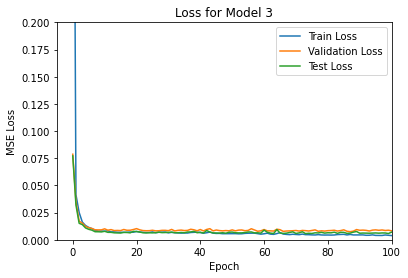

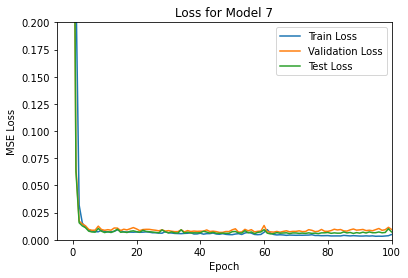

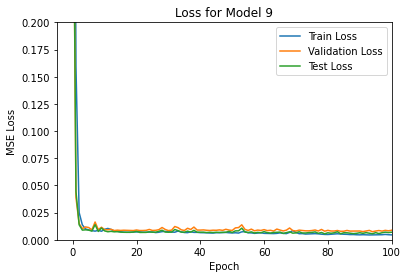

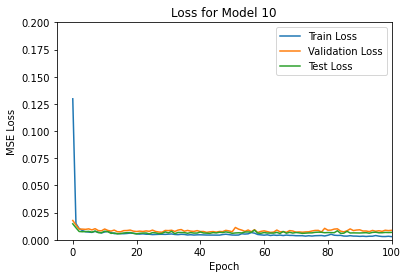

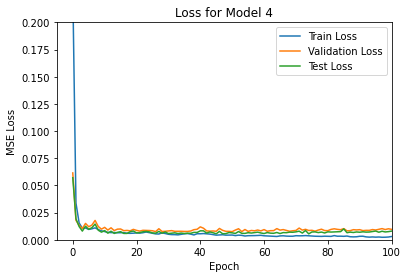

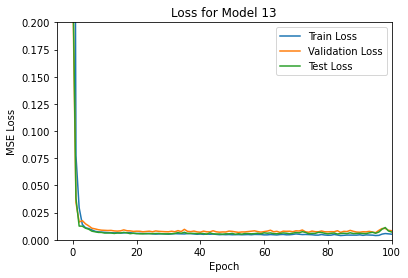

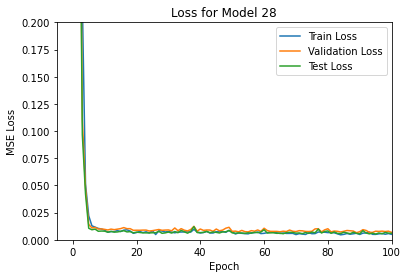

In [ ]:
plot_loss(df_model_1, 3, y_scale=[0,0.2])
plot_loss(df_model_2, 7, y_scale=[0,0.2])
plot_loss(df_model_3, 9, y_scale=[0,0.2])
plot_loss(df_model_4, 10, y_scale=[0,0.2])
plot_loss(df_model_5, 4, y_scale=[0,0.2])
plot_loss(df_model_6, 13, y_scale=[0,0.2])
plot_loss(df_model_7, 28, y_scale=[0,0.2])

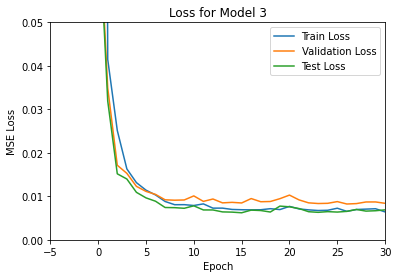

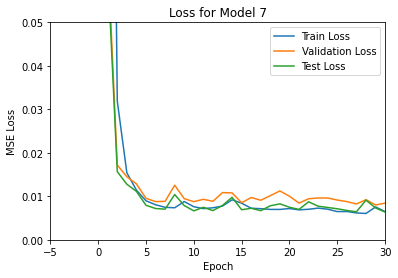

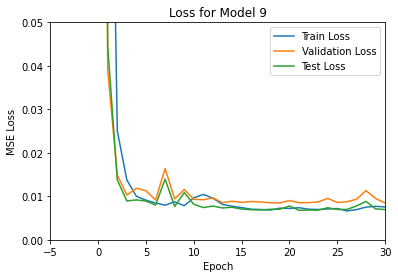

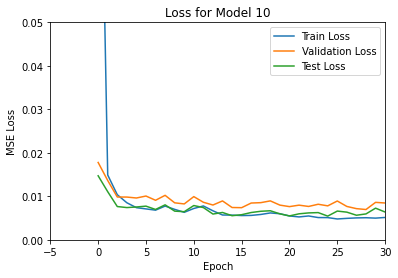

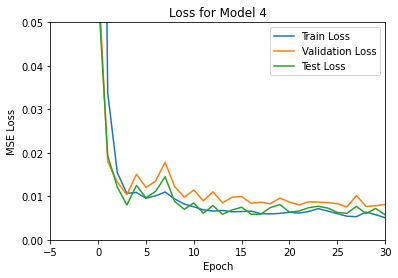

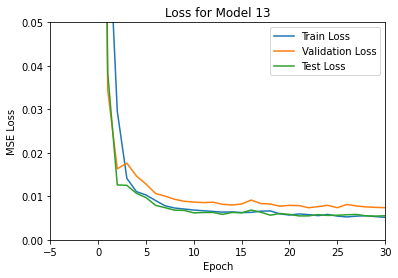

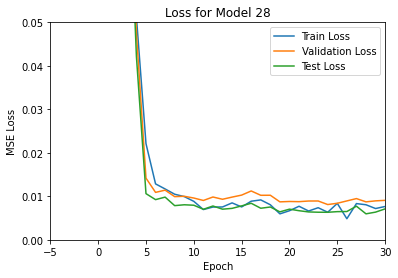

In [ ]:
plot_loss(df_model_1, 3, [0,0.05], epoch_range=[-5, 30])
plot_loss(df_model_2, 7, [0,0.05], epoch_range=[-5, 30])
plot_loss(df_model_3, 9, [0,0.05], epoch_range=[-5, 30])
plot_loss(df_model_4, 10, [0,0.05], epoch_range=[-5, 30])
plot_loss(df_model_5, 4, [0,0.05], epoch_range=[-5, 30])
plot_loss(df_model_6, 13, [0,0.05], epoch_range=[-5, 30])
plot_loss(df_model_7, 28, [0,0.05], epoch_range=[-5, 30])

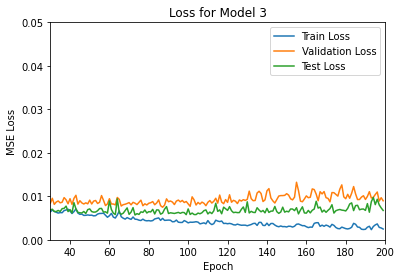

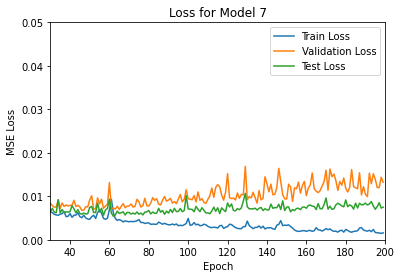

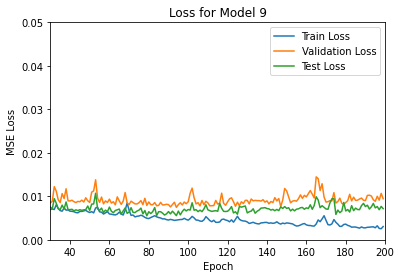

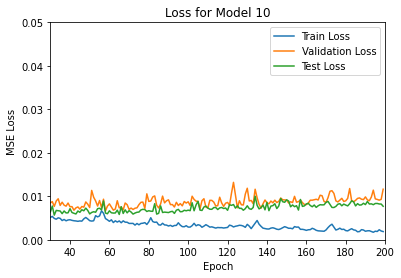

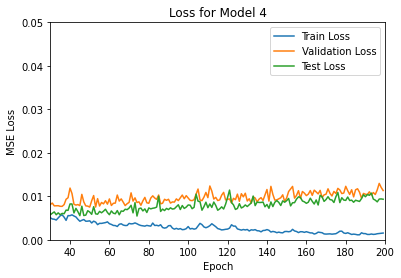

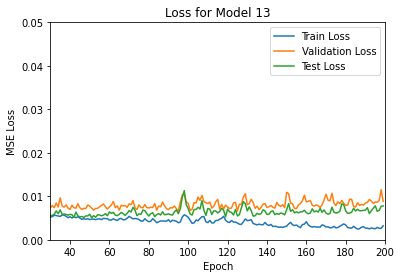

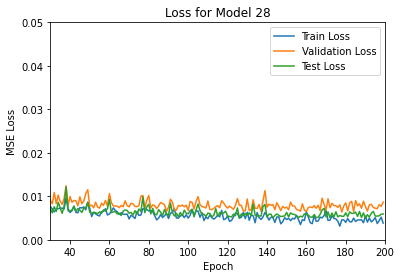

In [ ]:
plot_loss(df_model_1, 3, [0,0.05], epoch_range=[30, 200])
plot_loss(df_model_2, 7, [0,0.05], epoch_range=[30, 200])
plot_loss(df_model_3, 9, [0,0.05], epoch_range=[30, 200])
plot_loss(df_model_4, 10, [0,0.05], epoch_range=[30, 200])
plot_loss(df_model_5, 4, [0,0.05], epoch_range=[30, 200])
plot_loss(df_model_6, 13, [0,0.05], epoch_range=[30, 200])
plot_loss(df_model_7, 28, [0,0.05], epoch_range=[30, 200])